In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import yfinance as yf
import datetime
from arch import arch_model

In [2]:
ticker = 'AAPL'
data = yf.download(ticker, period='8d', interval='1m')
data = data.reset_index()
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data.head()



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Datetime,Close,High,Low,Open,Volume
0,2025-04-15 13:30:00+00:00,202.694595,202.869995,201.789993,201.854996,2412796
1,2025-04-15 13:31:00+00:00,202.744995,202.750000,202.160004,202.649994,312062
2,2025-04-15 13:32:00+00:00,202.294998,202.800003,202.070007,202.786804,263184
3,2025-04-15 13:33:00+00:00,202.339996,203.240005,202.309998,202.309998,399844
4,2025-04-15 13:34:00+00:00,202.547302,202.850006,202.033203,202.320007,296751


In [3]:
data['Return'] = data['Close'].pct_change()
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Date'] = data['Datetime'].dt.date
print(data.columns.tolist())

data = data.dropna(subset=['Return', 'Log_Return'])

print(data.columns)
print(data[['Datetime', 'Close', 'Return', 'Log_Return']].head())

['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'Log_Return', 'Date']
Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'Log_Return', 'Date'],
      dtype='object')
                   Datetime       Close    Return  Log_Return
1 2025-04-15 13:31:00+00:00  202.744995  0.000249    0.000249
2 2025-04-15 13:32:00+00:00  202.294998 -0.002220   -0.002222
3 2025-04-15 13:33:00+00:00  202.339996  0.000222    0.000222
4 2025-04-15 13:34:00+00:00  202.547302  0.001025    0.001024
5 2025-04-15 13:35:00+00:00  201.149994 -0.006899   -0.006923


First volatility value: 0.017591405857165145


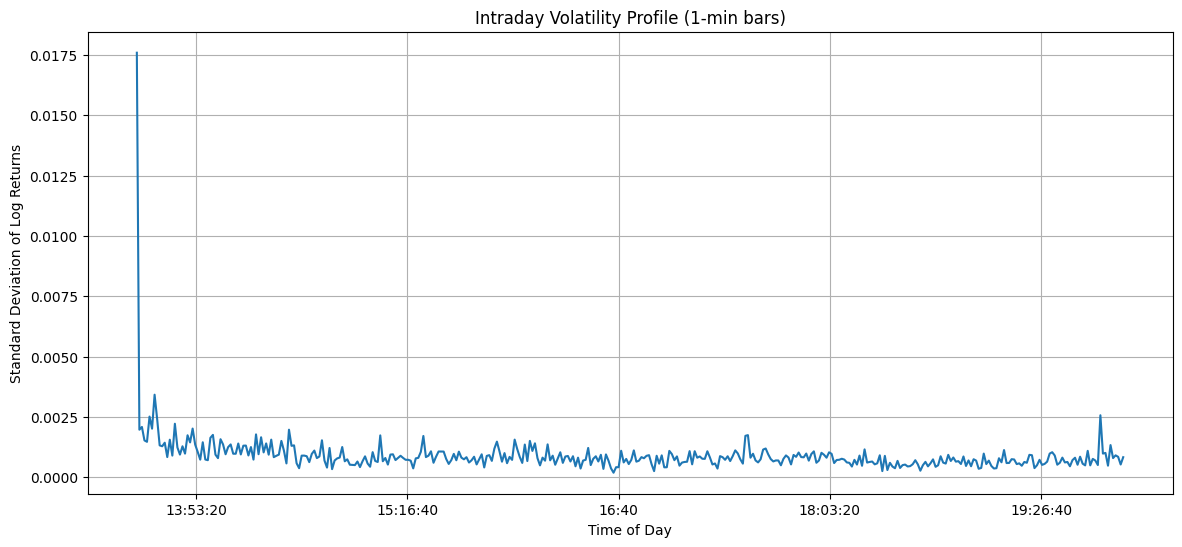

In [4]:
data['Time'] = data['Datetime'].dt.time
vol_profile = data.groupby('Time')['Log_Return'].std()

plt.figure(figsize=(14,6))
vol_profile.plot()
#print first volatility value
print(f"First volatility value: {vol_profile.iloc[0]}")
plt.title('Intraday Volatility Profile (1-min bars)')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns')
plt.grid()
plt.show()


In [5]:
daily_data = yf.download(ticker, period='60d', interval='1d')
daily_data = daily_data.reset_index()
daily_data.columns = [col[0] if isinstance(col, tuple) else col for col in daily_data.columns]

daily_data['Log_Return'] = np.log(daily_data['Close'] / daily_data['Close'].shift(1))
daily_data = daily_data.dropna(subset=['Log_Return'])

print(daily_data[['Date', 'Close', 'Log_Return']].head())



[*********************100%***********************]  1 of 1 completed

        Date       Close  Log_Return
1 2025-01-31  235.740814   -0.006715
2 2025-02-03  227.759583   -0.034442
3 2025-02-04  232.544327    0.020790
4 2025-02-05  232.214691   -0.001419
5 2025-02-06  232.963867    0.003221


In [6]:
#  fit GARCH(1,1) model here
am = arch_model(daily_data['Log_Return'] * 100, vol='Garch', p=1, q=1, mean='Zero')
res = am.fit(disp="off")

# forecast the volatility for the next day
forecast = res.forecast(horizon=1)
sigma_forecast = np.sqrt(forecast.variance.values[-1, :][0]) / 100
print(f"Forecasted daily volatility: {sigma_forecast:.4f}")

Forecasted daily volatility: 0.0249


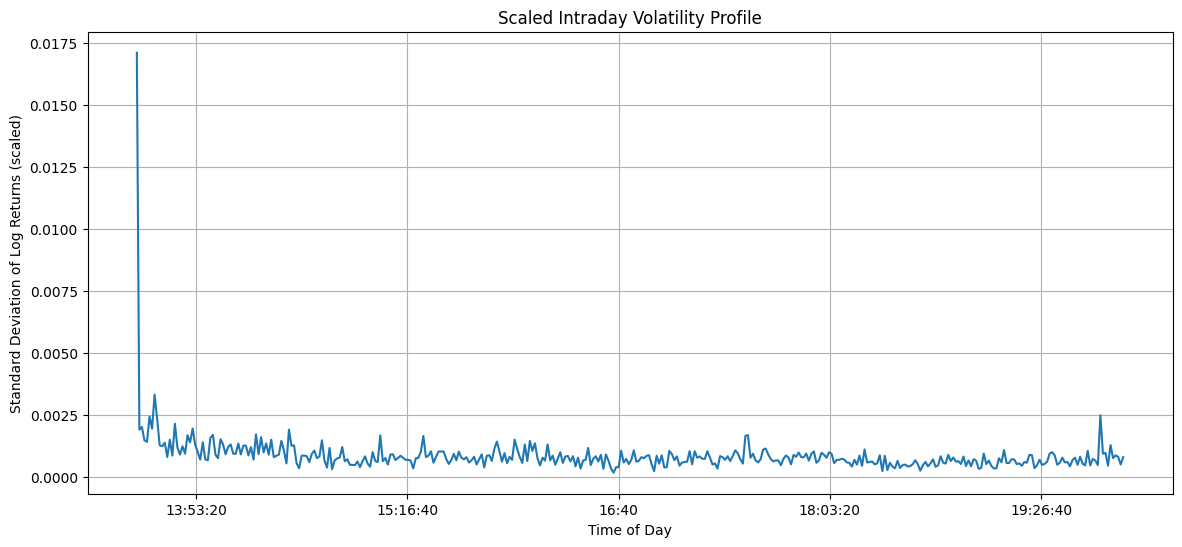

In [7]:
implied_variance = np.sum(vol_profile**2)

target_variance = sigma_forecast**2

scaling_factor = np.sqrt(target_variance / implied_variance)

scaled_vol_profile = vol_profile * scaling_factor

plt.figure(figsize=(14,6))
scaled_vol_profile.plot()
plt.title('Scaled Intraday Volatility Profile')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns (scaled)')
plt.grid()
plt.show()


In [8]:
daily_log_returns = data.groupby('Date')['Log_Return'].sum()
daily_log_returns = daily_log_returns.reset_index()
print(daily_log_returns.head(10))


         Date  Log_Return
0  2025-04-15   -0.002789
1  2025-04-16   -0.039508
2  2025-04-17    0.013140
3  2025-04-21   -0.019387
4  2025-04-22    0.033460
5  2025-04-23    0.023267
6  2025-04-24    0.018616
7  2025-04-25    0.004935


In [9]:
am = arch_model(daily_log_returns['Log_Return'] * 100, vol='Garch', p=1, q=1, mean='Zero')
res = am.fit(disp="off")
forecast_from_mins = res.forecast(horizon=1)
sigma_forecast_from_mins = np.sqrt(forecast_from_mins.variance.values[-1, :][0]) / 100
print(f"Forecasted daily volatility: {sigma_forecast_from_mins:.4f}")

Forecasted daily volatility: 0.0202


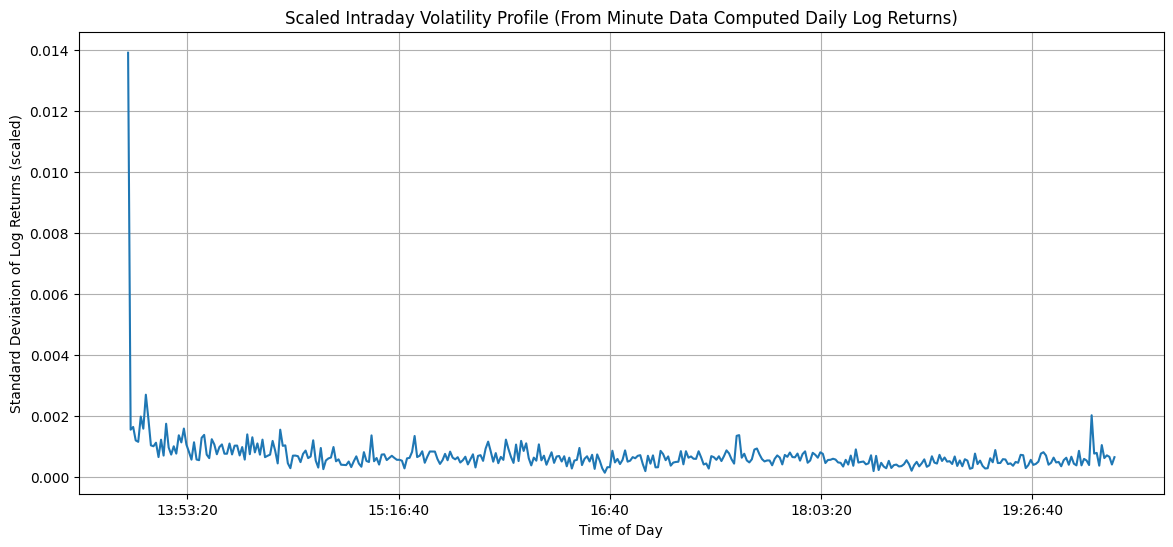

In [10]:
implied_variance = np.sum(vol_profile**2)

target_variance_from_mins = sigma_forecast_from_mins**2

scaling_factor_from_mins = np.sqrt(target_variance_from_mins / implied_variance)

scaled_vol_profile_from_mins = vol_profile * scaling_factor_from_mins

plt.figure(figsize=(14,6))
scaled_vol_profile_from_mins.plot()
plt.title('Scaled Intraday Volatility Profile (From Minute Data Computed Daily Log Returns)')
plt.xlabel('Time of Day')
plt.ylabel('Standard Deviation of Log Returns (scaled)')
plt.grid()
plt.show()


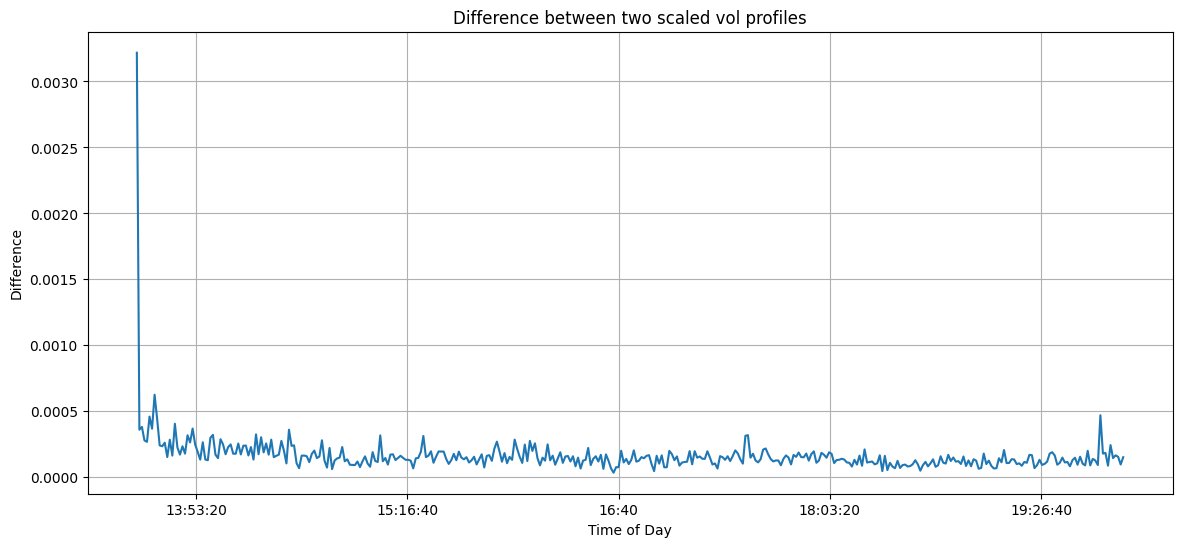

In [11]:
#compute difference between two scaled vol profiles
diff = scaled_vol_profile - scaled_vol_profile_from_mins
plt.figure(figsize=(14,6))
diff.plot()
plt.title('Difference between two scaled vol profiles')
plt.xlabel('Time of Day')
plt.ylabel('Difference')
plt.grid()
plt.show()

Cool, seems like I can get away with using the sum of log returns as an estimate of the volatility as my profile

In [12]:
def simulate_monte_carlo(scaled_vol_profile, start_price, num_simulations=1000, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    num_minutes = len(scaled_vol_profile)
    random_shocks = np.random.randn(num_simulations, num_minutes)
    returns = random_shocks * scaled_vol_profile.values
    cum_returns = np.cumsum(returns, axis=1)
    relative_prices = np.exp(cum_returns)
    prices = start_price * relative_prices
    return prices


def plot_simulation(prices, num_simulations=1000):
    plt.figure(figsize=(14,6))
    for i in range(num_simulations):
        plt.plot(prices[i], color='blue', alpha=0.1)
    plt.title('Monte Carlo Simulation of Price Paths')
    plt.xlabel('Time Steps (Minutes)')
    plt.ylabel('Price')
    plt.grid()
    plt.show()

In [13]:
today = datetime.date.today()

today_data = yf.download(ticker, period='1d', interval='1m', progress=False)
today_data = today_data.reset_index()

today_data.columns = [col[0] if isinstance(col, tuple) else col for col in today_data.columns]

today_data['Date'] = today_data['Datetime'].dt.date
today_data['Time'] = today_data['Datetime'].dt.time

if today_data.empty or today not in today_data['Date'].values:
    print("Today is NOT a trading day. Fetching most recent daily open instead.")

    fallback_data = yf.download(ticker, period='5d', interval='1d', progress=False)
    fallback_data = fallback_data.reset_index()

    last_open = fallback_data['Open'].iloc[-1]
    print(f"Most recent trading day's open: {last_open}")
    recent_open = last_open

else:
    print("Today is a trading day. Using today's open.")

    today_open = today_data['Open'].iloc[0]
    print(f"Today's open: {today_open}")
    recent_open = today_open


Today is NOT a trading day. Fetching most recent daily open instead.
Most recent trading day's open: Ticker
AAPL    206.369995
Name: 4, dtype: float64


/tmp/ipykernel_54649/2820041214.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(recent_open)


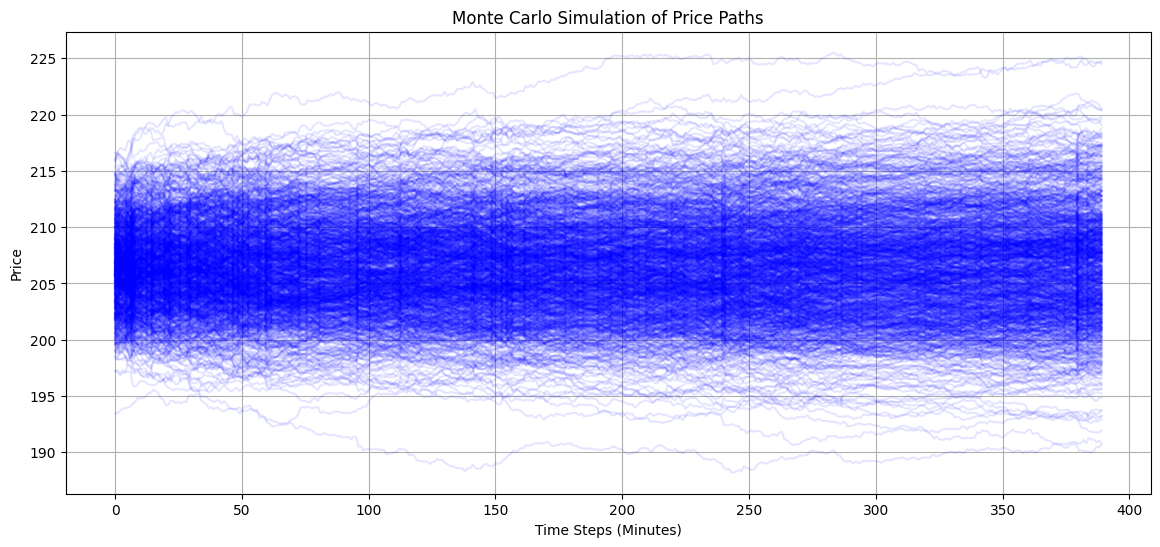

In [15]:
# run simulation using the open price of the most recent trading day
start_price = float(recent_open)
num_simulations = 1000
prices = simulate_monte_carlo(scaled_vol_profile, start_price, num_simulations=num_simulations, random_seed=42)
plot_simulation(prices, num_simulations=num_simulations)


In [ ]:
# get 95 percent confidence interval for close out of the simulations
lower_bound = np.percentile(prices[:, -1], 2.5)
upper_bound = np.percentile(prices[:, -1], 97.5)
print(f"95% confidence interval for close: {lower_bound:.2f} - {upper_bound:.2f}")
# get 99 percent confidence interval for close out of the simulations
lower_bound_99 = np.percentile(prices[:, -1], 0.5)  
upper_bound_99 = np.percentile(prices[:, -1], 99.5)
print(f"99% confidence interval for close: {lower_bound_99:.2f} - {upper_bound_99:.2f}")

95% confidence interval for close: 197.23 - 217.20
99% confidence interval for close: 193.25 - 219.80
